# Embeddings Approach

The embeddings approach is something which we've folded into its own module. The module is very strongly based around the `EmbeddingsApproach` class. 

In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
root_path = os.path.abspath(os.path.join(os.path.dirname(__file__), ".." ))
sys.path.insert(0, root_path)

In [10]:
from src.embeddings_approach import embeddings_approach
from src.azure_config import azure_config
from src.data_ingestion import data_ingestion
from src.model_assessment import model_assessment

First we need to make sure that our data is in the form we need. We have a couple of functions which will do this for us - the first of these will add `train, test, val` columns to each row. The second will add a column label for the feature we're trying to classify. 
Each of thes functions will re-register the dataset once these columns have been added. For that reason, I've commented these cells out, because there's no need to run them again. 

In [7]:
# data_ingestion.add_train_test_val_labels_to_df('published_80k_DanFinola')
# data_ingestion.add_train_test_val_labels_to_df('complaint-2521-DanFinola')

## Logging
We'll want to log our results as well. In the cell below, we'll call the relevant function from the `azure config` module to do this. 

**Importantly**, _runs_ are part of an _experiment_. If we want to compare multiple different models for a single given problem - like, we want to try different classifiers for the Complaints problem for example; we should make sure to register all of these under the same _experiment name_. 

Remember to execute `run.complete()` at the end of your script / notebook.

In [9]:
run = azure_config.start_run(expeiment_name="embeddings_example_run")

Now we're ready to do our hyperoptimisation. First of all we want to create our `embeddings_approach` object. Most of the arguments here are self explanatory. But it's worth emphasising a couple of things:
- The 'augmented_dataset_name_list' can be as long or short as you please. The optimiser will sample from all the datasets named in that list, and find the optimal amount to include. 
- The classifier class and be changed out, no need to stick with SVM. 
- The `name_of_column_to_embed` is the thing which we're trying to classify. This will almost always be the comment text, but could also be the title text, or these two concatenated etc. 
- The `positive_label_dataset_name_list` is a list of dataset names which hold the thing you're trying to build a classifier for. For example, this could be a list of dataset names of complaints data, or safeguarding data. 
  I've made this into a list because it's not unusual for us to get given new sets of data. This gives a simple way to incorporate when that happens
- The `negative_label_dataset_name_list` is a similar dataset name list, but in which the label is `0`. This will usually be the 80k published dataset. 

In [4]:
import sklearn
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

emb_1 = embeddings_approach.EmbeddingsApproach(
    classifier_class=sklearn.linear_model.SGDClassifier,
    augmented_dataset_name_list=[
        "complaints_generated_shuffle_v2",
        # "complaints_generated_embeddings_v2",
        # "complaints_generated_paraphrased_v2",
    ],
    # default_classifier_arguments=embeddings_approach.svm_space_arguments_default,
    default_classifier_arguments=embeddings_approach.sgd_classifier_space_arguments_default,
    model_for_embeddings_name="all-MiniLM-L6-v2",
    name_of_column_to_embed="Comment Text",
    name_of_y_column="Is Complaint",
    positive_label_dataset_name_list=["complaint-2521-DanFinola"],
    # negative_label_dataset_name_list=['published_80k_DanFinola']
    negative_label_dataset_name_list=["published_3k_DG_devset"],
    max_evals=5,
)

Embeddings already exist for complaints_generated_shuffle_v2
Embeddings made and registered for complaints_generated_shuffle_v2
Embeddings already exist for complaint-2521-DanFinola
Embeddings made and registered for complaint-2521-DanFinola
Embeddings already exist for published_3k_DG_devset
Embeddings made and registered for published_3k_DG_devset


Running the above cell, you might notice two things. The first is the warning:
`Failed to extract subscription information, Exception=AttributeError; 'Logger' object has no attribute 'activity_info'`
This is a warning which I haven't found a simple way to suppress. It's not an error and doesn't indicate a problem. 

The next thing is the print statement
`Embeddings already exist for complaints_generated_shuffle_v2`

Because we've chosen to re-register our datasets once we have 

Creating Optimised Classifier
100%|██████████| 5/5 [00:04<00:00,  1.12trial/s, best loss: -0.9060856498873028]
Winning values were:{'N_complaints_generated_shuffle_v2': 341, 'N_published_3k_DG_devset': 2330, 'alpha': 0.0001837123864401266, 'eta0': 0.0194451923441517, 'learning_rate': 3, 'loss': 3, 'penalty': 3}
assessor gotten


/anaconda/envs/jupyter_env/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(



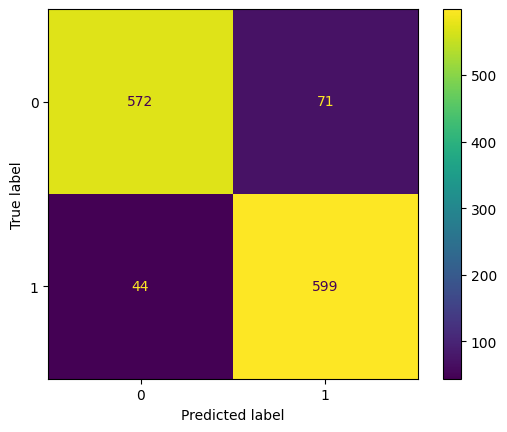

In [5]:
emb_1.find_optimised_classifier()
emb_1.make_and_fit_optimal_classifier()
emb_1.perform_analysis_on_optimised_model()

## Logging (again)
Now that we've created our optimal model and gotten results about it, we want to log those. Below we use three different methods to do this. These are kept seperate intentionally. 
- The first adds the model itself to the registry. It does this under a generated name, and adds all of the relevant parameters to the description field of that registered object. 
- The next one adds all of the parameters used to create the model to the run log. This means that when we're comparing different runs in the experiment we ought to be able to see which choices led to which results without too much hassle. 
- The last one adds all the assessment metrics to the log too. 

Found the config file in: /config.json


Model registered under the name pure-crane
All attributes logged


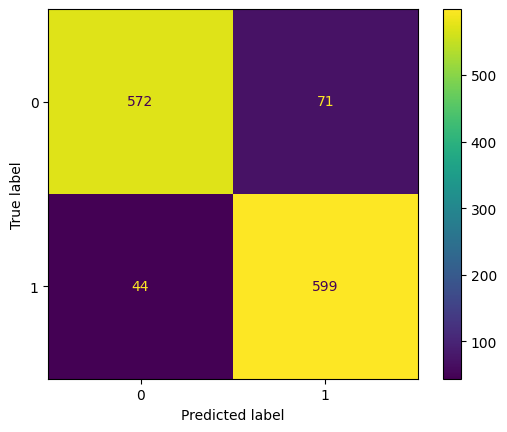

In [11]:
emb_1.register_optimal_model()
emb_1.log_all_attributes(run=run)
emb_1.assessor.log_all_metrics(run=run)
run.complete()

If there are any metrics missing from the assessor class which you'd like to see registered, just add them to the class as methods!